# **Classification of Gene Sequences Into Their Gene Families**

First, let's download the data for this notebook.

In [1]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

In [2]:
from utils import download_file

if not os.path.exists(path="data"):
    os.makedirs(name="data")

download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10493562",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fchimpanzee.txt&dl=1",
    save_filename="data/chimpanzee.txt",
)
download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10493561",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fdog.txt&dl=1",
    save_filename="data/dog.txt",
)
download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10493560",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fhuman.txt&dl=1",
    save_filename="data/human.txt",
)

Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fchimpanzee.txt&dl=1 -> data/chimpanzee.txt
Total size: 3,258,260 bytes


100%|██████████| 3.26M/3.26M [00:00<00:00, 7.39MiB/s]


Download completed: data/chimpanzee.txt
Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fdog.txt&dl=1 -> data/dog.txt
Total size: 1,667,375 bytes


100%|██████████| 1.67M/1.67M [00:00<00:00, 5.25MiB/s]


Download completed: data/dog.txt
Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fgene_family_classification%2Fhuman.txt&dl=1 -> data/human.txt
Total size: 5,547,716 bytes


100%|██████████| 5.55M/5.55M [00:00<00:00, 9.12MiB/s]

Download completed: data/human.txt


Second, let's group some imports here.

In [3]:
import re
from typing import Any, List

import numpy as np
import numpy.typing as npt

# Biological Sequence Representation for Machine Learning

Machine learning models generally require input to be numerical values organized in the form of feature matrices.
Biological sequence data is however usually provided in a string-like format.

There are three basic approaches to represent (or in other words, encode) biological sequence data:

1. Ordinal encoding
2. One-hot encoding
3. Biological sequences as a "language" through _k_-mer counting

Before we start, however, we need a function that harmonizes biological sequence strings and converts them into more convenient `numpy` arrays:

##### ❓ Converting biological sequence strings to `numpy` arrays

Complete the following function to harmonize (lowercase to uppercase, use `ACGTN` only) the biological sequence strings.

In [4]:
def sequence_to_array(sequence: str) -> npt.NDArray[Any]:
    """Convert a DNA sequence to a NumPy array."""
    # Harmonize lowercase and uppercase characters.
    sequence = sequence.upper()

    # Replace all characters in sequence that are not 'A', 'C', 'G', or 'T' with 'N'.
    sequence = re.sub(pattern="[^ACGT]", repl="N", string=sequence)

    # Format our output array.
    array = np.array(list(sequence))
    array = np.reshape(array, newshape=(len(array), 1))

    return array

In [5]:
print(sequence_to_array(sequence="GATTACA").T)

[['G' 'A' 'T' 'T' 'A' 'C' 'A']]


## Ordinal Encoding

In this approach, we encode bases (i.e., categorical features) as ordinal integers, i.e., integers having a relative ordering.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X=np.array([["A"], ["C"], ["G"], ["T"], ["N"]]))

array = sequence_to_array(sequence="GATTACAN")
encoded_sequence = ordinal_encoder.transform(X=array)

with np.printoptions(
    formatter={"float_kind": lambda x: f"{x:3.0f}", "str_kind": lambda x: f"  {x}"}
):
    print(f"Sequence:         {array.T}")
    print(f"Encoded sequence: {encoded_sequence.T}")

Sequence:         [[  G   A   T   T   A   C   A   N]]
Encoded sequence: [[  2   0   4   4   0   1   0   3]]


## One-Hot Encoding

Another approach is to use one-hot encoding to represent the biological sequence.
This is widely used in deep learning methods.
Each symbol gets transformed into a one-hot encoding vector.
A one-hot encoding vector is a vector in which all elements are zero except for one element which is set to one.
The position of the one in the vector encodes the symbol.
For further processing, these one-hot encoded vectors can for example be concatenated.

##### ❓ One-hot encoding for biological sequences

Similar to the ordinal encoding, implement and perform the one-hot encoding for the sequence `GATTACA`.
Use the `OneHotEncoder` class from `sklearn.preprocessing`.
When instantiating an encoder from the class, use `sparse_output=False`.

In [7]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoder.fit(X=np.array([["A"], ["C"], ["G"], ["T"], ["N"]]))

array = sequence_to_array(sequence="GATTACA")
encoded_sequence = onehot_encoder.transform(X=array)

with np.printoptions(
    formatter={"float_kind": lambda x: f"{x:3.0f}", "str_kind": lambda x: f"  {x}"}
):
    print(f"{array.T}")
    print(f"{encoded_sequence.T}")  # type: ignore

[[  G   A   T   T   A   C   A]]
[[  0   1   0   0   1   0   1]
 [  0   0   0   0   0   1   0]
 [  1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   1   1   0   0   0]]


## Biological Sequences as a "Language" Through K-Mer Counting

A hurdle that still remains is that none of these above methods results in arrays of uniform length, which is often a necessity.
So with the above methods, you have to resort to things like truncating sequences or padding with "N" to get arrays of uniform length.

Luckily there is the concept of _k_-mers.

_k_-mers are substrings of length $k$ contained within a biological sequence.
They are a fairly simple concept that turns out to be tremendously powerful.

Usually, the term _k_-mer refers to all of a sequence's subsequences of length $k$.
Using this definition, the sequence `ACGT` would have four monomers (`A`, `C`, `G`, `T`), three 2-mers (`AC`, `CG`, `GT`), two 3-mers (`ACG`, `CGT`), and one 4-mer (`ACGT`).
More generally, a sequence of length $L$ has $L - k + 1$ _k_-mers and $n^k$ total possible _k_-mers, where $n$ is the number of possible monomers.

In some sense, by using _k_-mers, we can also incorporate the concepts of "words" (_k_-mers) and "sentences" (sequences of _k_-mers) from natural language processing.

The following function `build_kmers()` returns a list of _k_-mer "words" for a given sequence.

In [8]:
def build_kmers(sequence: str, k: int) -> List[str]:
    """Build k-mers from a sequence."""
    return [sequence[i : i + k] for i in range(len(sequence) - k + 1)]

We can use this function to generate a language-like sentence from a biological sequence:

In [9]:
sequence = "GTGCCCAGGTTCAGTGA"
words = build_kmers(sequence=sequence, k=3)
sentence = " ".join(words)

print(f"Sequence : {sequence}")
print(f"Words    : {words}")
print(f"Sentence : {sentence}")

Sequence : GTGCCCAGGTTCAGTGA
Words    : ['GTG', 'TGC', 'GCC', 'CCC', 'CCA', 'CAG', 'AGG', 'GGT', 'GTT', 'TTC', 'TCA', 'CAG', 'AGT', 'GTG', 'TGA']
Sentence : GTG TGC GCC CCC CCA CAG AGG GGT GTT TTC TCA CAG AGT GTG TGA


In a next step, we may use a **Bag of Words** (BoW) model to represent our "sentence".

> A Bag of Words (BoW) model is a popular and simple way to represent text data in natural language processing (NLP) and information retrieval.
> In this model, a document is represented as an unordered set of words, disregarding grammar and word order but keeping track of word frequency.
> The name "Bag of Words" implies that the model is only concerned with the occurrence of words in a document, not with their order or structure.

> Here's how the Bag of Words model typically works:
>
> 1. Tokenization: The first step is to break down a text into individual words or tokens. This process involves removing punctuation, converting all words to lowercase, and splitting the text into individual words.
> 2. Vocabulary Building: Create a vocabulary of all unique words in the entire corpus (collection of documents). Each unique word in this vocabulary is assigned a unique index.
> 3. Vectorization: Represent each document as a vector in the space of the vocabulary. The vector has the same length as the vocabulary, and each element of the vector corresponds to the frequency of a word from the vocabulary in the document.

> Here's a simple example:
>
> Consider two documents:
>
> - Document 1: "The cat in the hat."
> - Document 2: "The quick brown fox."
> - The vocabulary is: {the, cat, in, hat, quick, brown, fox}.
>
> The Bag of Words representation for these documents would be:
>
> - Document 1: [2, 1, 1, 1, 0, 0, 0]
> - Document 2: [1, 0, 1, 0, 1, 1, 1]

##### ❓ Employing the BoW model in the context of biological sequence data

The BoW model can&nbsp;&mdash;&nbsp;analogous to its use in NLP&nbsp;&mdash;&nbsp;be employed for biological sequence data.

1. Use the function `build_kmers()` to build a word corpus from the given sequence corpus. Use $k=3$.
2. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to fit the BoW model to the word corpus.
3. Vectorize new "documents" using the trained BoW model.

> Use the function `toarray()` to convert sparse matrix objects returned by `CountVectorizer`s `transform()` and `fit_transform()` functions into dense representation as a NumPy array.

In [10]:
sequence_corpus = ["GATTCCAG", "GATTACA", "NAAGT"]

In [11]:
# Build the word corpus.

word_corpus = [
    build_kmers(sequence=sequence_corpus[i], k=3) for i in range(len(sequence_corpus))
]
word_corpus = [item for sublist in word_corpus for item in sublist]
word_corpus = " ".join(word_corpus)

print(f"Word corpus: {word_corpus}")

Word corpus: GAT ATT TTC TCC CCA CAG GAT ATT TTA TAC ACA NAA AAG AGT


In [12]:
# Fit the BoW model to the word corpus.

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
word_vectorization = vectorizer.fit_transform(raw_documents=[word_corpus])

print(f"Word vectorization: {word_vectorization.toarray()}")  # type: ignore
print(f"Feature names: {vectorizer.get_feature_names_out()}")

Word vectorization: [[1 1 1 2 1 1 2 1 1 1 1 1]]
Feature names: ['aag' 'aca' 'agt' 'att' 'cag' 'cca' 'gat' 'naa' 'tac' 'tcc' 'tta' 'ttc']


In [13]:
# Vectorize new documents using the trained BoW model.

print(vectorizer.transform(["GAT ATT TTA TAC CAG"]).toarray())  # type: ignore
print(vectorizer.transform(["GAT ATT ACA ACA ACA"]).toarray())  # type: ignore

[[0 0 0 1 1 0 1 0 1 0 1 0]]
[[0 3 0 1 0 0 1 0 0 0 0 0]]


# A Real-World End-to-End Exercise

In this end-to-end exercise, the goal is to classify gene sequences into their gene families.

We provide gene sequences from three species in the `data/` folder:

- [Chimpanzee](https://en.wikipedia.org/wiki/Chimpanzee) (_Pan troglodytes_): `chimpanzee.txt`
- [Dog](https://en.wikipedia.org/wiki/Dog) (_Canis familiaris_): `dog.txt`
- [Human](https://en.wikipedia.org/wiki/Human) (_Homo sapiens_): `human.txt`

Each file contains two tab-separated columns.
The first column (column header: `sequence`) contains the relevant gene sequence.
The second column (column header: `class`) contains the corresponding gene family, coded as integer:

| Identifier | Gene family                         |
|------------|-------------------------------------|
|          0 | G protein-coupled receptors (GPCRs) |
|          1 | Tyrosine kinase                     |
|          2 | Tyrosine phosphatase                |
|          3 | Synthetase                          |
|          4 | Synthase                            |
|          5 | Ion channel                         |
|          6 | Transcription factor                |

##### ❓ Reading data in with `pandas`

Use `pandas`' [`read_table()`](https://pandas.pydata.org/docs/reference/api/pandas.read_table.html) function to read in the three files.

In [14]:
import pandas as pd

chimp_dna = pd.read_table(filepath_or_buffer="data/chimpanzee.txt")
dog_dna = pd.read_table(filepath_or_buffer="data/dog.txt")
human_dna = pd.read_table(filepath_or_buffer="data/human.txt")

In [15]:
human_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


##### ❓ Building _k_-mer "words" for the data

Convert the sequences into short overlapping _k_-mer "words" of length $k=6$.
For now, do this only for the human data.
Add the _k_-mer words as additional column to the `human_dna` dataframe.

In [16]:
human_dna["words"] = human_dna.apply(lambda x: build_kmers(x["sequence"], k=6), axis=1)
human_dna.head()

,sequence,class,words
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,"[ATGCCC, TGCCCC, GCCCCA, CCCCAA, CCCAAC, CCAAC..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,"[ATGAAC, TGAACG, GAACGA, AACGAA, ACGAAA, CGAAA..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,"[ATGCAA, TGCAAC, GCAACA, CAACAG, AACAGC, ACAGC..."


##### ❓ Building "sentences"

For the human data, convert the lists of _k_-mers into sentences of words (separated by one whitespace) that can be used to fit the BoW model.

In [17]:
human_corpus = [" ".join(words) for words in human_dna["words"]]

##### ❓ Fit a BoW model

Use the `CountVectorizer` from `sklearn.feature_extraction.text` to fit a BoW model to the `human_corpus`.
Also, vectorize the entire corpus.

> Play around with the `ngram_range` argument of `CountVectorizer()` to introduce more context into the vectorizations.

In [18]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
human_vectorizations = vectorizer.fit_transform(raw_documents=human_corpus)
print(f"Vectorizations shape: {human_vectorizations.shape}")

Vectorizations shape: (4380, 21303)


##### ❓ Split the data into a training and a test set

Extract the class labels from the `human_dna` dataframe.
Then, use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from `sklearn.model_selection` to split the vectorizations _and_ the class labels into a training set (80%) and a test set (20%).

In [19]:
from sklearn.model_selection import train_test_split

y_human = human_dna["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    human_vectorizations, y_human, test_size=0.20, random_state=42
)

##### ❓ Train a classifier

Take a classifier of your choice to classify the data.

> Try for example:
>
> - `sklearn.naive_bayes.MultinomialNB`
> - `sklearn.tree.DecisionTreeClassifier`
> - `sklearn.ensemble.RandomForestClassifier`

In [20]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X=X_train, y=y_train)
y_pred = clf.predict(X=X_test)

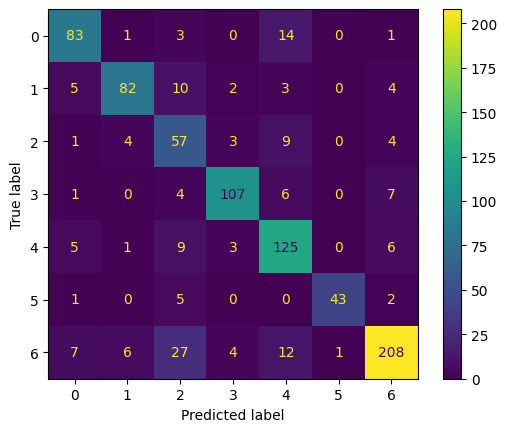

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f"Accuracy  : {accuracy_score(y_true=y_test, y_pred=y_pred):.4f}")
print(
    f"Precision : "
    f"{precision_score(y_true=y_test, y_pred=y_pred, average='weighted'):.4f}"
)
print(
    f"Recall    : {recall_score(y_true=y_test, y_pred=y_pred, average='weighted'):.4f}"
)
print(f"F1 score  : {f1_score(y_true=y_test, y_pred=y_pred, average='weighted'):.4f}")

Accuracy  : 0.8048
Precision : 0.8257
Recall    : 0.8048
F1 score  : 0.8109


# Enhancements

- Try to use different `max_depth`s for the `DecisionTreeClassifier`.
- The classes are imbalanced. Try to upsample the minority classes using `resample()` from `sklearn.utils`. Also try to downsample the majority class(es).
- It could be beneficial to tune some hyperparameters (e.g., `CountVectorizer`'s `ngram_range` parameter and the _k_-mer length).